Step 1: Train/Test Split

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.load("../preprocessing/6_less_tensor.npz")
X = data["inputs"]
Y = data["outputs"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(len(X_train), len(X_test))

74265 8252


Step 2: CNN Architecture (Pytorch)

In [2]:
import torch
import torch.nn as nn
from ChessMoveCNN import ChessMoveCNN # see ChessMoveCNN.py

Step 3: Loss Function and Training Setup

In [3]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ChessMoveCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

cuda


Step 4: Training Loop

In [4]:
train_losses = []
test_losses = []
epochs = 20

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

Epoch 1/20 - Train Loss: 0.0369 - Test Loss: 0.0277
Epoch 2/20 - Train Loss: 0.0270 - Test Loss: 0.0268
Epoch 3/20 - Train Loss: 0.0258 - Test Loss: 0.0257
Epoch 4/20 - Train Loss: 0.0251 - Test Loss: 0.0249
Epoch 5/20 - Train Loss: 0.0247 - Test Loss: 0.0252
Epoch 6/20 - Train Loss: 0.0243 - Test Loss: 0.0244
Epoch 7/20 - Train Loss: 0.0241 - Test Loss: 0.0245
Epoch 8/20 - Train Loss: 0.0240 - Test Loss: 0.0239
Epoch 9/20 - Train Loss: 0.0239 - Test Loss: 0.0238
Epoch 10/20 - Train Loss: 0.0238 - Test Loss: 0.0240
Epoch 11/20 - Train Loss: 0.0237 - Test Loss: 0.0235
Epoch 12/20 - Train Loss: 0.0237 - Test Loss: 0.0237
Epoch 13/20 - Train Loss: 0.0236 - Test Loss: 0.0240
Epoch 14/20 - Train Loss: 0.0236 - Test Loss: 0.0240
Epoch 15/20 - Train Loss: 0.0235 - Test Loss: 0.0238
Epoch 16/20 - Train Loss: 0.0235 - Test Loss: 0.0237
Epoch 17/20 - Train Loss: 0.0234 - Test Loss: 0.0234
Epoch 18/20 - Train Loss: 0.0234 - Test Loss: 0.0236
Epoch 19/20 - Train Loss: 0.0233 - Test Loss: 0.0233
Ep

Step 5: Loss Plotting and Test Case Visualization

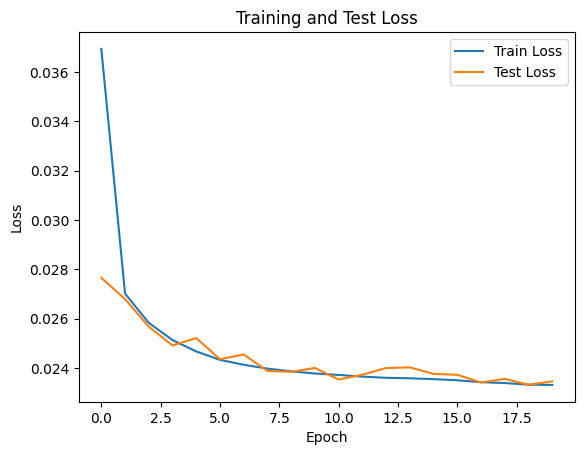

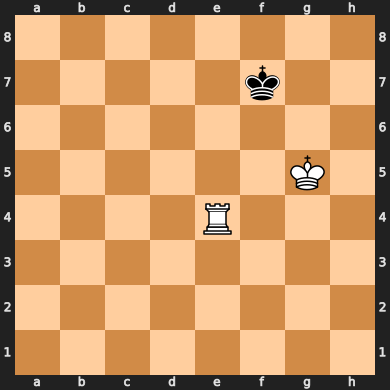

Top 5 predicted moves (start, end, uci, score):
f7g7: 0.6550
f7f8: 0.2270
f7g8: 0.1280

Ground Truth Move: f7g7


In [5]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()

import sys
sys.path.insert(1, '../preprocessing/')
import utils

import chess

def get_top_5_moves(pred_tensor, board):
    pred = torch.sigmoid(pred_tensor).detach().cpu().numpy()  # shape (2, 8, 8)
    start_map = pred[0]
    end_map = pred[1]

    scored_moves = []
    for move in board.legal_moves:
        start = move.from_square  # 0-63
        end = move.to_square      # 0-63

        start_score = start_map[start // 8][start % 8]
        end_score = end_map[end // 8][end % 8]
        score = float(start_score * end_score)

        scored_moves.append((score, start, end))

    top5 = sorted(scored_moves, key=lambda x: -x[0])[:5]
    return [
        (chess.square_name(s), chess.square_name(e), f"{chess.square_name(s)}{chess.square_name(e)}", score)
        for score, s, e in top5
    ]

# Pick a test sample
idx = np.random.randint(len(X_test))
x = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(device)
y_pred = model(x)[0]  # shape: (2, 8, 8)

board = utils.tensor_to_board(X_test[idx])
display(board)
top5_moves = get_top_5_moves(y_pred, board)

print("Top 5 predicted moves (start, end, uci, score):")
for start, end, uci, score in top5_moves:
    print(f"{uci}: {score:.4f}")

y_true = Y_test[idx]  # shape: (2, 8, 8)
# Find the '1' (or highest value) in the start plane and end plane
start_idx = np.argmax(y_true[0].flatten()) 
end_idx   = np.argmax(y_true[1].flatten()) 

# Convert to square names just like the predicted moves
start_sq = chess.square_name(start_idx)
end_sq   = chess.square_name(end_idx)
true_uci = f"{start_sq}{end_sq}"

print("\nGround Truth Move:", true_uci)

100%|██████████| 8252/8252 [01:47<00:00, 77.11it/s]

Top-1 Accuracy: 0.448
Top-5 Accuracy: 0.894


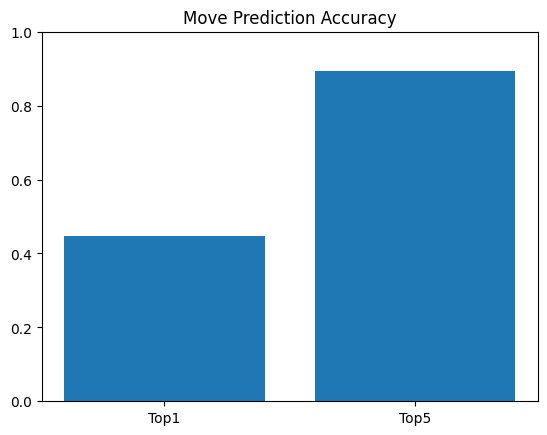

In [6]:
# New cell to compute and plot Top-1 and Top-5 Accuracy
import matplotlib.pyplot as plt
from tqdm import tqdm

top1_correct = 0
top5_correct = 0
num_samples = len(X_test)

for i in tqdm(range(num_samples)):
    # Model prediction
    x = torch.tensor(X_test[i:i+1], dtype=torch.float32).to(device)
    y_pred = model(x)[0]  # shape: (2, 8, 8)

    # Ground-truth move (assuming y_test has shape [N, 2, 8, 8])
    y_true = Y_test[i]
    start_idx = np.argmax(y_true[0].flatten())  # index 0..63
    end_idx   = np.argmax(y_true[1].flatten())  # index 0..63
    gt_start  = chess.square_name(start_idx)    # e.g. "a2"
    gt_end    = chess.square_name(end_idx)      # e.g. "a3"

    # Get predicted top-5 moves
    # (start_str, end_str, uci_str, score)
    board = utils.tensor_to_board(x[0])
    top5_moves = get_top_5_moves(y_pred, board)

    # Check if Top-1 matches ground truth
    top1_move = top5_moves[0]
    if top1_move[0] == gt_start and top1_move[1] == gt_end:
        top1_correct += 1

    # Check if ground truth is in Top-5
    for (start_str, end_str, uci_str, score) in top5_moves:
        if start_str == gt_start and end_str == gt_end:
            top5_correct += 1
            break

top1_accuracy = top1_correct / num_samples
top5_accuracy = top5_correct / num_samples

print(f"Top-1 Accuracy: {top1_accuracy:.3f}")
print(f"Top-5 Accuracy: {top5_accuracy:.3f}")

# Plot as a simple bar chart
plt.bar(["Top1", "Top5"], [top1_accuracy, top5_accuracy])
plt.ylim(0, 1)
plt.title("Move Prediction Accuracy")
plt.show()

In [8]:
torch.save(model.state_dict(), "endplay_weights.pth")

torch.save()